In [1]:
!pip install torchviz

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------------- 47.1/47.1 kB 1.2 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4137 sha256=b78a37804881e5d3faab7affddf4d80fef67b3ee2fffaf5904ee725bb989eaf3
  Stored in directory: c:\users\perso\appdata\local\pip\cache\wheels\4c\97\88\a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

In [4]:
# 나눔 고딕 폰트의 경로 명시
path = 'C:/Windows/Fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

##### 초기설정

In [6]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [7]:
# GPU 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# 공통함수 읽어오기 (9장)

# 공통함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통함수 임포트
from pythonlibs.torch_lib1 import *

# 공통함수 체크
print(README)

Common Library for PyTorch
Author: M. Akaishi


Cloning into 'pythonlibs'...


##### 학습 데이터 읽어오기

In [10]:
# 학습용 이미지 다운로드
## 패스

# 학습, 테스트 디렉토리명 설정
import os

data_dir = './dog_wolf/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_dir

'./dog_wolf/train'

In [15]:
# 분류 클래스 설정
classes = ['dog', 'wolf']

!tree dog_wolf

DATABANK ������ ���� ���� ����� ����Դϴ�.
���� �Ϸ� ��ȣ�� E65D-4084�Դϴ�.
D:\01_PROGRAMMING\100_HUGOBANK\MINE\STUDY-PYTORCH\WIKIBOOK_LEARNING\DOG_WOLF
����test
��  ����dog
��  ����wolf
����train
    ����dog
    ����wolf


In [20]:
# 학습용 데이터 준비하기

# transform 의 정의
# 검증 데이터용: 정규화만을 실시
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 학습 데이터용: 정규화에 RandomHorizontalFlip 과 RandomErasing 을 추가로 실시
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

# dataset 정의
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# dataloader 정의
batch_size = 5
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=False)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)

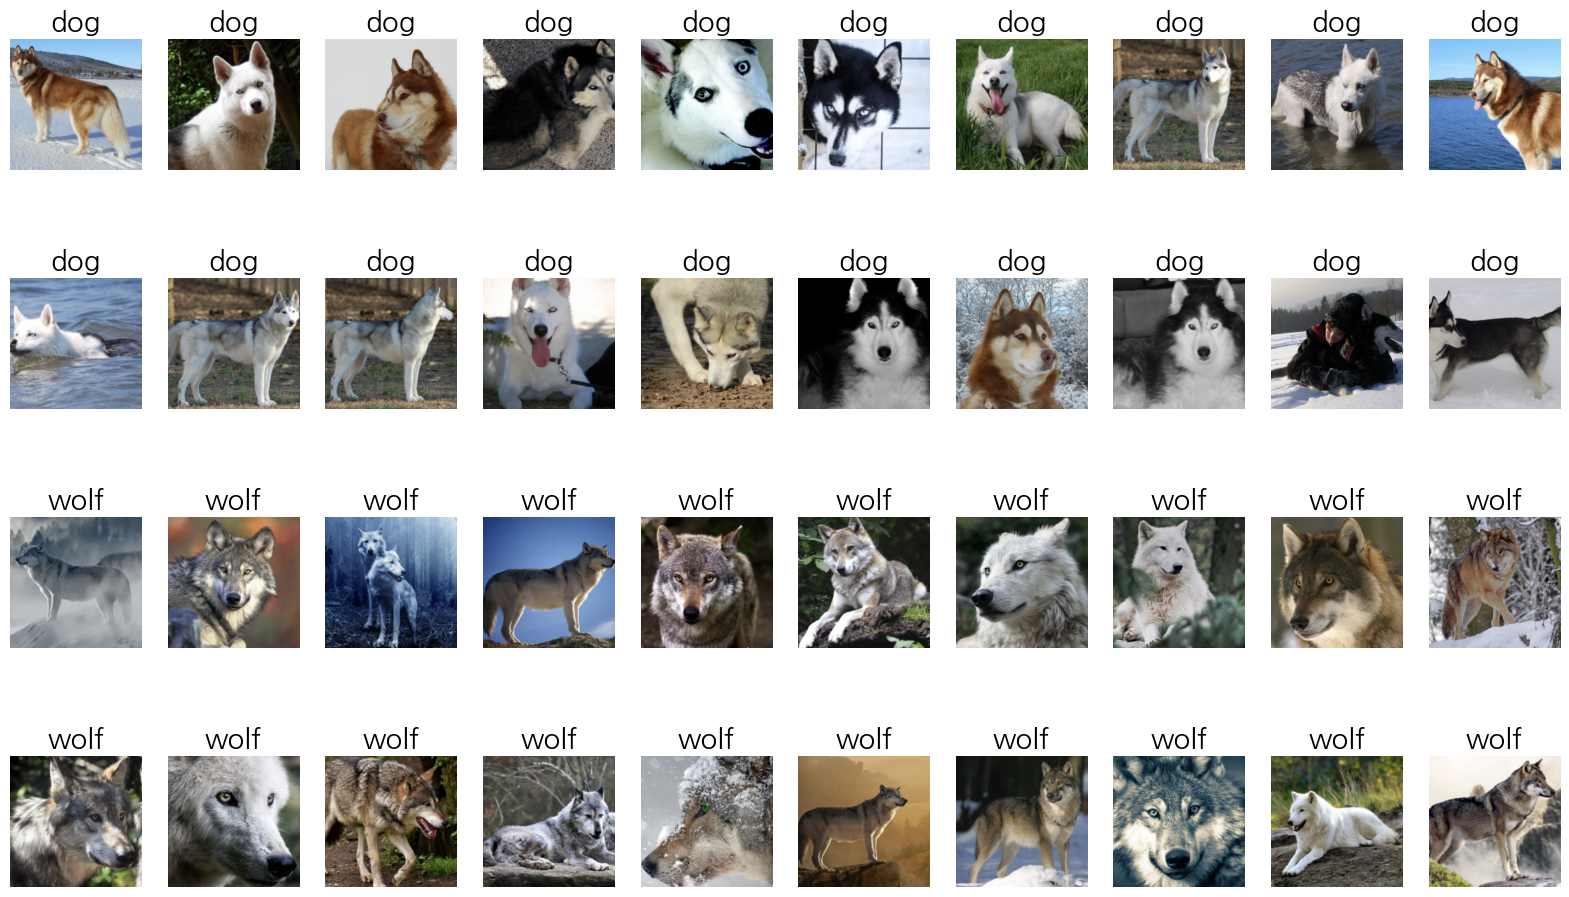

In [21]:
## 학습이미지 데이터 확인
show_images_labels(train_loader2, classes, None, None)

##### 검증 이미지 데이터 확인

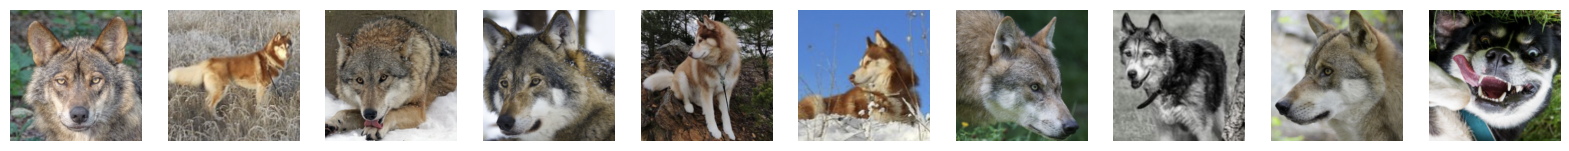

In [22]:
# 검증용 데이터 (10건)
# 우선 정답 라벨 없이 이미지만을 표시합니다.
# 각 사진이 개와 늑대중 어떤 것인지 각자 판단해 보기 바랍니다.
torch_seed()
show_images_labels(test_loader2, ['', ''], None, None)

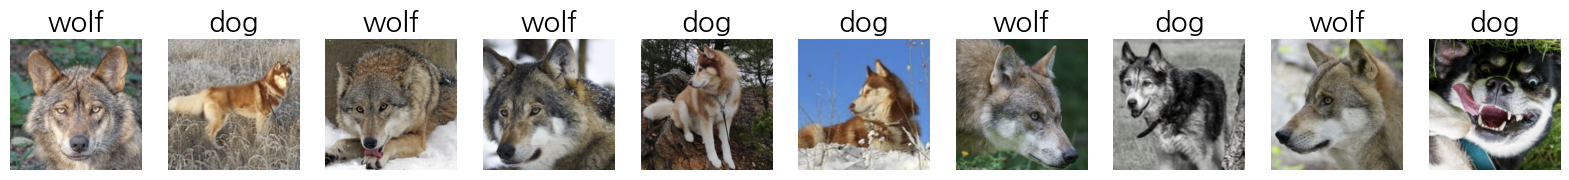

In [23]:
# 검증용 데이터 (10건)
# 이것이 정답 데이터 입니다.
# 10건 중 몇 건의 정답을 맞췄습니까.
torch_seed()
show_images_labels(test_loader2, classes, None, None)

##### 모델 구축

In [24]:
# 사전에 학습이 끝난 모델을 이용해서 모델을 구축 (11장)

# 사전에 학습이 끝난 모델 읽어오기
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 전이 학습을 위해 required_grad 그래프를 False 로 설정
for param in net.parameters():
    param.requires_grad = False

# 난수 고정
torch_seed()

# 마지막 노드의 출력을 2로 변경
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수로 교차 엔트로피 사용
criterion = nn.CrossEntropyLoss()

# 최적화함수 정의

# 파라미터 수정 대상을 마지막 노드로 제한함
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# history 파일을 동시에 초기화
history = np.zeros((0, 5))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\perso/.cache\torch\hub\checkpoints\vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:11<00:00, 50.8MB/s] 


##### 학습

In [25]:
# 학습(9장)
# 반복 횟수
num_epochs = 10

# 학습 (공통함수)
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.12345 acc: 0.65000 val_loss: 0.07783, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.07584 acc: 0.85000 val_loss: 0.04895, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.03976 acc: 0.92500 val_loss: 0.05762, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.04213 acc: 0.92500 val_loss: 0.03992, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.01836 acc: 0.97500 val_loss: 0.02970, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.02144 acc: 0.97500 val_loss: 0.04182, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.03019 acc: 0.95000 val_loss: 0.03631, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.04319 acc: 0.92500 val_loss: 0.03186, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.01086 acc: 1.00000 val_loss: 0.02766, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.04419 acc: 0.92500 val_loss: 0.03189, val_acc: 1.00000


##### 결과 확인

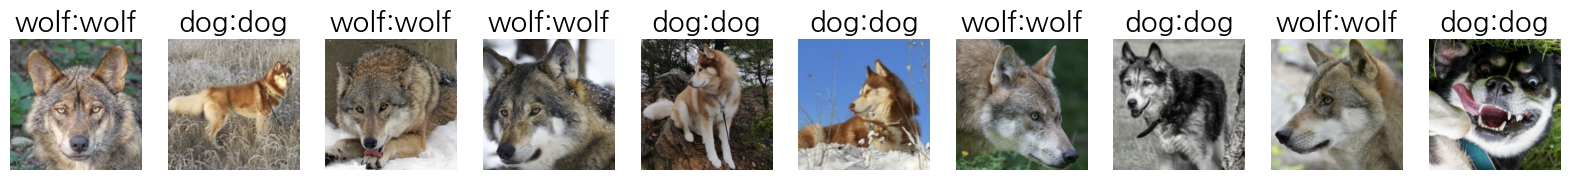

In [26]:
# 검증 데이터를 대상으로 결과 확인 (9장 공통함수)
torch_seed()
show_images_labels(test_loader2, classes, net, device)

##### 공통함수의 내부 구조

In [27]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
    
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 학습 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 그라디언트 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 그라이언트 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답을 맞춘 수 산출
            train_acc += (predicted == labels).sum()

            # 평균 손실값과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답을 맞춘 수 산출
            val_acc += (predicted == labels).sum()

            # 평균 손실값과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [28]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 최초 한 세트의 이미지와 라벨을 취득
    for images, labels in loader:
        break
    # 표시 수는 숫자 50과 배치사이즈를 비교해 작은 쪽을 선택
    n_size = min(len(images), 50)

    if net is not None:
        # 디바이스에 데이터 할당
        inputs = images.to(device)
        labels = labels.to(device)

        # 예측 계산
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
        #images = images.to('cpu')

    # 최초 n_size 만큼 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net 이 None 이 아니면 예측 결과도 타이틀에 표기
        if net is not None:
            predicted_name = classes[predicted[i]]
            # 정답 여부를 색으로 나눔
            if label_name == predicted_name:
                c = 'k'
            else:
                c = 'b'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net 가 None 일 경우는 정답 라벨만을 표시
        else:
            ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를 [-1, 1] -> [0, 1] 로 되돌리기
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [29]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms = True